In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from models import *
%matplotlib inline

In [2]:
# hyper-parameters
# how many samples per batch to load
batch_size = 25
# percentage of training set to use as validation
valid_size = 0.1
# number of epochs to train the model
n_epochs = 30
# track change in validation loss
valid_loss_min = np.Inf
# specify the image classes
classes = ['noise', 'wave']
# gpu
DEVICE = torch.device('cuda: 3' if torch.cuda.is_available() else 'cpu')

In [3]:
# choose the training and test datasets
train_set = pd.read_csv("./data/mass/exp1/data1.2/train.csv", dtype=np.float32)

# Seperate the features and labels
total_train_label = train_set.label.values
total_train_data = train_set.loc[:, train_set.columns != 'label'].values
total_train_data  = total_train_data.reshape(-1, 1, 4096)

# Split into training and test set
data_train, data_valid, label_train, label_valid = train_test_split(total_train_data, total_train_label, test_size=0.1, random_state=2)

In [4]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
dataTrain = torch.from_numpy(data_train)
labelTrain = torch.from_numpy(label_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for valid set.
dataValid = torch.from_numpy(data_valid)
labelValid = torch.from_numpy(label_valid).type(torch.LongTensor) # data type is long

In [5]:
# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(dataTrain,labelTrain)
valid = torch.utils.data.TensorDataset(dataValid,labelValid)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

In [6]:
# instantiate model
model =  ConvNet4().to(DEVICE)
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
#learning rate
lr_sched = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# summary
#summary(model, input_size=(1,4096))

In [7]:
#curve list
train_Loss_list = []
valid_Loss_list = []
accracy_list = []
valid_len = 20

In [8]:
# train
for epoch in range(0, n_epochs):

    # keep track of training, validation loss and correct
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0.0
    # train the model 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE).float().reshape(batch_size, 1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        #valid more
        if (batch_idx + 1) % valid_len == 0:
            class_correct = list(0. for i in range(2))
            class_total = list(0. for i in range(2))
            # validate the model 
            model.eval()
            for data, target in valid_loader:
                data, target = data.to(DEVICE), target.to(DEVICE).float().reshape(batch_size, 1)
                output = model(data)
                loss = F.binary_cross_entropy(output, target)
                valid_loss += loss.item()*data.size(0)
                # less the limit 0.5->0.1, higher the recall rate
                pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(DEVICE)  
                # compare predictions to true label
                correct_tensor = pred.eq(target.data.view_as(pred).long())
                correct = np.squeeze(correct_tensor.cpu().numpy())
                # calculate test accuracy for each object class
                for i in range(batch_size):
                    label = target.data[i].int()
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

            # calculate accuracy
            accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
            # calculate average losses
            train_loss = train_loss / (valid_len * batch_size)
            valid_loss = valid_loss / len(valid_loader.dataset)
            #curve data
            train_Loss_list.append(train_loss)
            valid_Loss_list.append(valid_loss)
            accracy_list.append(accuracy)
            
            # print training/validation statistics 
            if((epoch * 10 + (batch_idx + 1) / valid_len) % 5 == 0):
                print('iteration: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                    epoch * 10 + (batch_idx + 1) / valid_len, train_loss, valid_loss))

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), './param/exp1_data1.2_convnet4.pt')
                valid_loss_min = valid_loss
            train_loss = 0.0
            valid_loss = 0.0
    # learning rate
    lr_sched.step()

Validation loss decreased (inf --> 0.687406).  Saving model ...
Validation loss decreased (0.687406 --> 0.681616).  Saving model ...
Validation loss decreased (0.681616 --> 0.676216).  Saving model ...
iteration: 5.0 	Training Loss: 0.670587 	Validation Loss: 0.667222
Validation loss decreased (0.676216 --> 0.667222).  Saving model ...
Validation loss decreased (0.667222 --> 0.648601).  Saving model ...
Validation loss decreased (0.648601 --> 0.642810).  Saving model ...
Validation loss decreased (0.642810 --> 0.621476).  Saving model ...
Validation loss decreased (0.621476 --> 0.600710).  Saving model ...
Validation loss decreased (0.600710 --> 0.559009).  Saving model ...
Validation loss decreased (0.559009 --> 0.469705).  Saving model ...
Validation loss decreased (0.469705 --> 0.414217).  Saving model ...
iteration: 15.0 	Training Loss: 0.427971 	Validation Loss: 0.370859
Validation loss decreased (0.414217 --> 0.370859).  Saving model ...
Validation loss decreased (0.370859 --> 0.

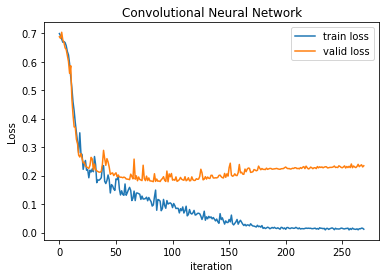

In [9]:
length = len(train_Loss_list)
x = range(0, length)
plt.plot(x, train_Loss_list, label='train loss')
plt.plot(x, valid_Loss_list, label='valid loss')
plt.title('Convolutional Neural Network')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("cnn_loss.jpg")
plt.show()

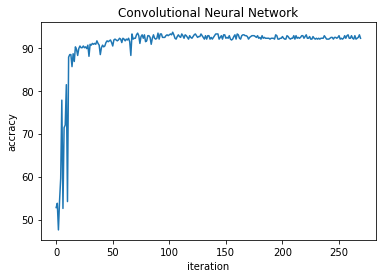

In [10]:
length = len(accracy_list)
x = range(0, length)
plt.plot(x, accracy_list)
plt.title('Convolutional Neural Network')
plt.xlabel('iteration')
plt.ylabel('accracy')
#plt.savefig("cnn_loss.jpg")
plt.show()

In [11]:
#np.savetxt('./cache/new/data_1.2_convnet1/accracy.txt',accracy_list,fmt="%.6f",delimiter="\n")
#np.savetxt('./cache/new/data_1.2_convnet1/train_Loss_list.txt',train_Loss_list,fmt="%.6f",delimiter="\n")
#np.savetxt('./cache/new/data_1.2_convnet1/valid_Loss_list.txt',valid_Loss_list,fmt="%.6f",delimiter="\n")

In [12]:
model.load_state_dict(torch.load('./param/exp1_data1.2_convnet4.pt'))

<All keys matched successfully>

In [13]:
test_set = pd.read_csv("./data/mass/exp1/data1.2/test.csv", dtype=np.float32)

# Seperate the features and labels
label_test = test_set.label.values
data_test = test_set.loc[:, test_set.columns != 'label'].values
data_test  = data_test.reshape(-1, 1, 4096)

# create feature and targets tensor for test set.
dataTest = torch.from_numpy(data_test)
labelTest = torch.from_numpy(label_test).type(torch.LongTensor) # data type is long

test = torch.utils.data.TensorDataset(dataTest,labelTest)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE).float().reshape(batch_size, 1)
    output = model(data)
    loss = F.binary_cross_entropy(output, target)
    test_loss += loss.item()*data.size(0)
    # less the limit 0.5->0.1, higher the recall rate
    pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(DEVICE)  
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred).long())
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i].int()
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.180455

Test Accuracy of noise: 93% (234/250)
Test Accuracy of  wave: 93% (233/250)

Test Accuracy (Overall): 93% (467/500)
